# Gradient Boosting

Esta técnica consiste en aprender árboles de regresión sencillos sobre los datos, y después otro sobre los errores que comete el anterior para corregirlos.<br>
Este proceso se puede extender durante varias iteraciones, de manera que al final la estimación es la suma de  las estimaciones realizadas por todos los clasificadores entrenados.

---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2021, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2021, URJC (Spain)

    alfredo.cuesta@urjc.es

### Preliminares 

En la siguiente celda se realizan los siguientes pasos:
1. carga de módulos genéricos
2. leer los datos y cargarlos en dataframes
2. extraer características
2. separar en TRAIN y VALID
2. seleccionar características y escalar TRAIN a [0,1]

In [1]:
#-[1]. Load data from CSV and put all in a single dataframe 'FullSet'

import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../MyUtils/')
import MyUtils as my
seed = 1234 #<- random generator seed (comment to get randomness)

#-[2]. Load data from CSV and put all in a single dataframe 'FullSet'

FullSet_0 = pd.read_csv('../Datasets/1000ceros.csv', header=None)
FullSet_1 = pd.read_csv('../Datasets/1000unos.csv',  header=None)
FullSet = my.join_features_labels(FullSet_0,FullSet_1)

#-[3]. Convert the 'FullSet' of pixels into the set 'X_full' of features and get the set 'Y_full' of labels

theta = 0.5
X_full = my.mnist_features( FullSet.drop('label', axis=1), theta=theta )
Y_full = FullSet[['label']]

#-[4]. Split X_full into TRAIN and TEST in a single Stratified split

valid_size = 0.2
X_train, Y_train, X_valid, Y_valid = \
   my.single_stratified_split( X_full,Y_full, test_size=valid_size, random_state=seed)

#-[5]. Select the features and fit a scaler to [0,1]

from sklearn.preprocessing import MinMaxScaler

feat_selec= ['width','height']
#feat_selec= ['W_max1','H_max1']
scaler = MinMaxScaler()

X = scaler.fit_transform(X_train[feat_selec])
Y = Y_train.values.ravel()  

#---> X and Y are now numpy arrays ready to train a machine !!

## Combinación por *GradientBoosting*

Al igual que en Random Forests (RF), no hace falta especificar el clasificador base porque de manera implicita es el DT.<br> 
Y al igual que en RF, también se pueden configurar sus hiperparámetros.

Más en [*GradientBoostingClassifier*, de Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)


#### Entrenar

In [2]:
# --- LEARN GradientBoosting ensemble --------------

from sklearn.ensemble import GradientBoostingClassifier

max_depth = 1
n_estimators = 100
learning_rate= 1

gb_clf = GradientBoostingClassifier(max_depth=max_depth,        \
                                    n_estimators=n_estimators,  \
                                    learning_rate=learning_rate)

gb_clf.fit(X, Y)

GradientBoostingClassifier(learning_rate=1, max_depth=1)

#### Testear

In [3]:
# --- TEST -----------------------------------------------
from sklearn.metrics import accuracy_score

Y_pred = gb_clf.predict(scaler.transform(X_valid[feat_selec]))
accuracy = accuracy_score(Y_valid, Y_pred)

print("accuracy = ",accuracy)

accuracy =  0.93


#### Visualizar

In [4]:
#--parameters of this cell
Ngrid = 100
#threshold = 0.5 # Set 0 < threshold < 1 to make a hard classification.
cmap = 'summer'  # 'jet' 'hot' 'cool' 'spring' 'summer' 'winter'

#--take Ngrid x Ngrid equally spaced points in [0,1]x[0,1]
rangeX = np.linspace(0,1,Ngrid)
rangeY = np.linspace(0,1,Ngrid)
xx,yy = np.meshgrid(rangeX,rangeY)
grid_data = np.hstack( (xx.reshape([xx.size,1]),    \
                        yy.reshape([yy.size,1]) ) )

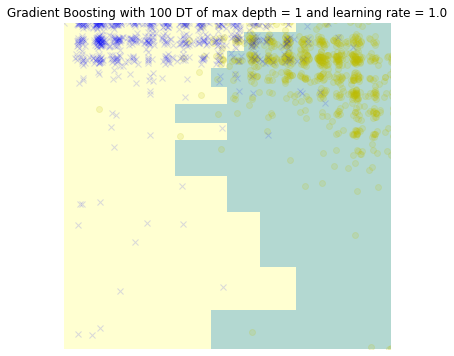

In [5]:
unit_interv = [0,1,0,1]
origin = 'lower'
plt.rcParams['figure.figsize'] = [6,6] #<- this makes the figures larger in Jupyter

sigma=0.01
alpha=0.3

tag_hat = gb_clf.predict(grid_data)
tag_hat = tag_hat.reshape([Ngrid,Ngrid])
ix1 = Y>0
ix0 = ~ix1
x1_zeros = my.jitter(X[ix0,0],sigma=sigma)
x2_zeros = my.jitter(X[ix0,1],sigma=sigma)
x1_ones = my.jitter(X[ix1,0],sigma=sigma)
x2_ones = my.jitter(X[ix1,1],sigma=sigma)
plt.imshow(tag_hat, origin="lower", extent=unit_interv, cmap=cmap, alpha=alpha)
plt.plot(x1_zeros, x2_zeros, 'yo', alpha=.15)
plt.plot(x1_ones, x2_ones, 'bx', alpha=.15)

strTitle = "Gradient Boosting with %d DT of max depth = %d and learning rate = %1.1f" \
    %(n_estimators,max_depth,learning_rate)
plt.title(strTitle)
plt.axis(unit_interv)

plt.axis('off')

plt.show()